In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

In [2]:
from src.modules.classification_data_model import ClassificationDataset, Classification_Model
from src.tools.dataset_tools import get_dataset_filename_map, dataset_gdrive_download, get_labels, save_images_in_folders
import config_cfw
import os
import numpy as np

# download celeba dataset
# dataset_gdrive_download(config = config_cfw)

# get labels map
labels_map = get_dataset_filename_map(config = config_cfw)
print('keys', labels_map.keys())
print('Number of class in label map', len(list(labels_map.keys())) )

print('\ntesting dataset')

num_classes = 2


dataset = ClassificationDataset(labels_map, num_classes=list(range(num_classes)), map_to_int=True, offset_y=0)
print('nb samples', len(dataset))
print('nb classes in dataloader', dataset.nb_classes())

keys dict_keys(['OpenFace', 'ClosedFace'])
Number of class in label map 2

testing dataset
nb samples 2423
nb classes in dataloader 2


 Train dataset ----------------------------




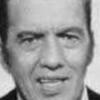

label 0
shape (100, 100)




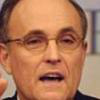

label 0
shape (100, 100)


In [3]:
print(" Train dataset ----------------------------")
for i, (image, label) in enumerate(dataset):
    print("\n")
    display(image)
    print("label",label)
    print('shape', image.size)
    if i==1:
        break

# Dataloader

In [4]:
import multiprocessing as mp
from src.modules.classification_data_model import DATASETS

batch_size = 16
dataloader = Classification_Model(name=DATASETS.CFW, nb_classes=num_classes, class_split=False, 
                                  batch_size = batch_size, splitting_points=(0.10, 0.10), 
                                  input_shape = (3, 256, 256), num_workers = mp.cpu_count(),
                                  in_folders=True, finetune=True, image_aug_p=0.25,)

dataloader.setup()

train_loader = dataloader.train_dataloader()
val_loader = dataloader.val_dataloader()
test_loader = dataloader.test_dataloader()

print("Number of train batches", len(train_loader))
print("Number of valid batches", len(val_loader))
if test_loader is not None:
    print("Number of test batches", len(test_loader))

Augment Image train
Images not Augmented val
len 2423
split size [1939, 242, 242]
Number of train batches 122
Number of valid batches 8
Number of test batches 8


max value 1.0
min value 0.0
shape torch.Size([16, 3, 256, 256])
[tensor(0), tensor(1), tensor(0), tensor(1), tensor(1)]


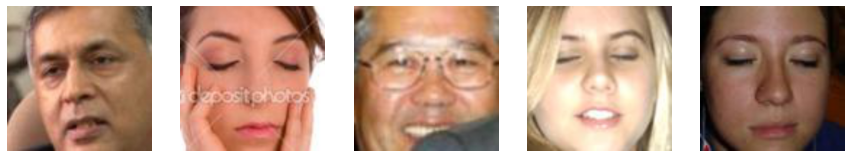

In [5]:
#Dataloader samples
from src.tools.visualization_tools import visualize_torch
import torch

for i, (im, label) in enumerate(train_loader):
    print('max value', torch.max(im).item())
    print('min value', torch.min(im).item())
    print('shape', im.shape)
    visualize_torch(im)
    
    print(list(label[0:5]))
    
    if i == 0:
        break

max value 1.0
min value 0.0
shape torch.Size([32, 3, 256, 256])
[tensor(1), tensor(0), tensor(0), tensor(0), tensor(0)]


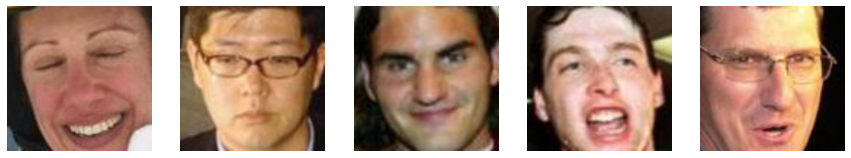

In [6]:
for i, (im, label) in enumerate(val_loader):
    print('max value', torch.max(im).item())
    print('min value', torch.min(im).item())
    print('shape', im.shape)
    visualize_torch(im)
    
    print(list(label[0:5]))
    
    if i == 0:
        break

max value 1.0
min value 0.0
shape torch.Size([32, 3, 256, 256])
[tensor(0), tensor(1), tensor(0), tensor(0), tensor(1)]


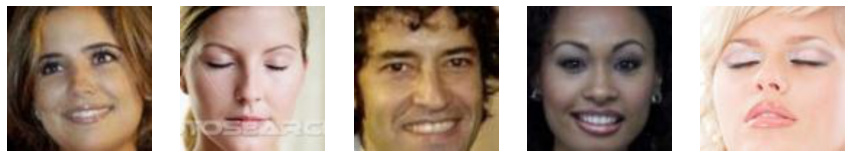

In [7]:
if test_loader is not None:
    for i, (im, label) in enumerate(test_loader):
        print('max value', torch.max(im).item())
        print('min value', torch.min(im).item())
        print('shape', im.shape)
        visualize_torch(im)

        print(list(label[0:5]))

        if i == 0:
            break

# Training the model

In [8]:
from src.model.CFW_Model import Classification_Trainer
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from torch import nn
from torchsummary import summary
import model_configs


num_classes = 2

checkpoint_path = os.path.join('data', 'checkpoint', 'group_loss_tuned_2of24_all_data_finetuned',
                                            'Group-epoch=17-val_loss=1.44-val_R%_@1=81.12.ckpt')
model = Classification_Trainer(hparams=model_configs.get_cfw_hparam(), 
                scheduler_params = model_configs.get_cfw_scheduler_param(),
                nb_classes = 1,
                pretrained_classes=10177,
                checkpoint_path=checkpoint_path,
                     )

no layers freezed
no layers freezed
Layers to update
	 last_linear.weight
	 last_linear.bias


In [9]:
if torch.cuda.is_available():
    model.to('cuda')


print()
print('model summary')
print(summary(model,[ (3, model.input_size, model.input_size)]))
model.cpu()
print("Model input size", model.input_size)


model summary
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,160
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8          [-1, 192, 56, 56]         110,784
       BatchNorm2d-9          [-1, 192, 56, 56]             384
             ReLU-10          [-1, 192, 56, 56]               0
        MaxPool2d-11          [-1, 192, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]          12,352
      BatchNorm2d-13           [-1, 64, 28, 28]             128
             ReLU-14    

In [10]:
batch_size = 48

dataloader = Classification_Model(name=DATASETS.CFW,
                                  nb_classes=1, 
                                  class_split=False, 
                                  batch_size=batch_size, 
                                  splitting_points=(0.10, 0.10), 
                                  input_shape =  (3, model.input_size, model.input_size),
                                  num_workers = mp.cpu_count(),
                                  in_folders=True,
                                  finetune=True,
                                  image_aug_p=0,
                                  )

# dataloader = Classification_Model(name=DATASETS.CFW, nb_classes=num_classes, class_split=False, 
#                                   batch_size = batch_size, splitting_points=(0.10, 0.10), 
#                                   input_shape = (3, 256, 256), num_workers = mp.cpu_count(),
#                                   in_folders=True, finetune=True)

dataloader.setup()

train_loader = dataloader.train_dataloader()
val_loader = dataloader.val_dataloader()
test_loader = dataloader.test_dataloader()

print("Number of train batches", len(train_loader))
print("Number of valid batches", len(val_loader))
if test_loader is not None:
    print("Number of test batches", len(test_loader))

for i, batch in enumerate(train_loader):
    x, y = batch
    print(x.shape)
    break

Images not Augmented train
Images not Augmented val
len 1231
split size [985, 123, 123]
Number of train batches 21
Number of valid batches 2
Number of test batches 2
torch.Size([48, 3, 224, 224])


In [11]:
exp_name = 'test'

early_stop_callback = pl.callbacks.EarlyStopping(
    monitor='val_acc',
    patience=20,
    strict=True,
    verbose=False,
    mode='max'
)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_acc',
    dirpath=f'data/checkpoint/{exp_name}',
    filename='Group-{epoch:02d}-{val_acc:.2f}',
    save_top_k=5,
    mode='max',
)

lr_monitor = pl.callbacks.LearningRateMonitor()


callbacks = []

callbacks = [
    early_stop_callback,
    checkpoint_callback,
    lr_monitor,
]

trainer_params = {
    "check_val_every_n_epoch": 1, 
    "callbacks": callbacks,
    "fast_dev_run": False,
    "max_epochs": 100,
    "gpus":1 if torch.cuda.is_available() else None,
}

# logname = 'resnet_BCE'
logger = TensorBoardLogger(os.path.join('data','tb_log_liveness_detection'), name=exp_name)

do_train = True

trainer = pl.Trainer(**trainer_params, logger = logger)
if do_train:
    trainer.fit(model, dataloader)

/home/kareem/PycharmProjects/whos_that_pokemon/venv/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Checkpoint directory data/checkpoint/test exists and is not empty. With save_top_k=5, all files in this directory will be deleted when a checkpoint is saved!
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | criterion | BCEWithLogitsLoss | 0     
1 | model     | BNInception       | 10.3 M


/home/kareem/PycharmProjects/whos_that_pokemon/venv/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


# Manual Saving

In [12]:
import os
from src.tools.checkpoint_tools import save_model_txt, load_model_txt

save_checkpoint = False
if save_checkpoint:
    save_dir = os.path.join('data', 'checkpoint', 'finetune_inc')  
    checkpoint_path = os.path.join(save_dir, 'Group-epoch=09-val_loss=2.29.ckpt')
    trainer.save_checkpoint(checkpoint_path)


save_ibm = False
if save_ibm:
    ibm_dir = os.path.join(checkpoint_callback.dirpath, 'ibm')
    if not os.path.exists(ibm_dir):
        os.mkdir(ibm_dir)
        
    save_path = os.path.join(ibm_dir, 'Group-epoch=24-val_loss=1.53-val_R%_@1=78.84.txt')
    save_model_txt(model, save_path)

# Load Checkpoint

In [13]:
load_checkpoint = False

model = Classification_Trainer(nb_classes=1)

if load_checkpoint:
#     checkpoint_path = checkpoint_callback.best_model_path
    checkpoint_path = os.path.join(checkpoint_callback.dirpath, 'Group-epoch=33-val_acc=0.88.ckpt')
    model = model.load_from_checkpoint(checkpoint_path=checkpoint_path)
    
load_ibm = False
if load_ibm:
    load_path = os.path.join(checkpoint_callback.dirpath, 'ibm', 'Group-epoch=23-val_loss=2.96.txt')
    load_model_txt(model, load_path)

Layers to update
	 conv1_7x7_s2.weight
	 conv1_7x7_s2.bias
	 conv1_7x7_s2_bn.weight
	 conv1_7x7_s2_bn.bias
	 conv2_3x3_reduce.weight
	 conv2_3x3_reduce.bias
	 conv2_3x3_reduce_bn.weight
	 conv2_3x3_reduce_bn.bias
	 conv2_3x3.weight
	 conv2_3x3.bias
	 conv2_3x3_bn.weight
	 conv2_3x3_bn.bias
	 inception_3a_1x1.weight
	 inception_3a_1x1.bias
	 inception_3a_1x1_bn.weight
	 inception_3a_1x1_bn.bias
	 inception_3a_3x3_reduce.weight
	 inception_3a_3x3_reduce.bias
	 inception_3a_3x3_reduce_bn.weight
	 inception_3a_3x3_reduce_bn.bias
	 inception_3a_3x3.weight
	 inception_3a_3x3.bias
	 inception_3a_3x3_bn.weight
	 inception_3a_3x3_bn.bias
	 inception_3a_double_3x3_reduce.weight
	 inception_3a_double_3x3_reduce.bias
	 inception_3a_double_3x3_reduce_bn.weight
	 inception_3a_double_3x3_reduce_bn.bias
	 inception_3a_double_3x3_1.weight
	 inception_3a_double_3x3_1.bias
	 inception_3a_double_3x3_1_bn.weight
	 inception_3a_double_3x3_1_bn.bias
	 inception_3a_double_3x3_2.weight
	 inception_3a_double_3x

# Evaluate Model

In [14]:
trainer.test(model, dataloader.val_dataloader())

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'acc': tensor(0.), 'avg_loss': tensor(0.6998)}
--------------------------------------------------------------------------------



/home/kareem/PycharmProjects/whos_that_pokemon/venv/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The testing_epoch_end should not return anything as of 9.1.to log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)


[{'avg_loss': 0.699813961982727, 'acc': 0.0}]

In [15]:
trainer.test(model, dataloader.test_dataloader())

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'acc': tensor(0.), 'avg_loss': tensor(0.6998)}
--------------------------------------------------------------------------------



[{'avg_loss': 0.699813961982727, 'acc': 0.0}]

# Visualization

In [ ]:
from src.tools.model_tools import inference
from torch.utils import data


for x, y in dataloader.test_dataloader():
    y_hat = model.infer(x)
    visualize_torch(x[:5])
    print("labels", y_hat.squeeze()[:5])
    print("predictions", y.squeeze()[:5])
    break